<a href="https://colab.research.google.com/github/adhithyasash1/ml-prac/blob/main/21f3000611.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting missing data, Feature Engineering and Imputation

In [38]:
import warnings
warnings.filterwarnings('ignore')

import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.utils import shuffle
from sklearn.experimental import enable_iterative_imputer  # Explicitly enable IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score, classification_report

# Load the datasets
train_data = pd.read_csv('/content/drive/MyDrive/mlp_data/train.csv')
movies_data = pd.read_csv('/content/drive/MyDrive/mlp_data/movies.csv')
test_data = pd.read_csv('/content/drive/MyDrive/mlp_data/test.csv')

Detecting missing values

In [39]:
# Detecting missing values in movies dataset before merging for information
missing_values_count_movies_data = movies_data.isnull().sum()
print(missing_values_count_movies_data)

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64


In [40]:
# Modifications for movies_data, by removing redundant columns with large missing values, which might introduce biases when we impute them for model supply

# List of columns to drop, Dropping the specified columns from the DataFrame and assigning the result to a new DataFrame
columns_to_drop = ['boxOffice', 'distributor', 'soundType', 'rating', 'ratingContents', 'releaseDateTheaters', 'releaseDateStreaming']
movies_data = movies_data.drop(columns_to_drop, axis=1)

Outlier removal to prevent skewage in data:

* Outliers can skew statistical measures like mean and standard deviation, leading to biased model performance. Removing outliers can result in a more accurate representation of the data distribution and prevent models from being biased toward extreme values.

* ML models aim to generalize patterns from the training data to new, unseen data. Outliers can cause models to overfit to unusual data points that may not be representative of the broader population. Removing outliers can help improve model generalization.

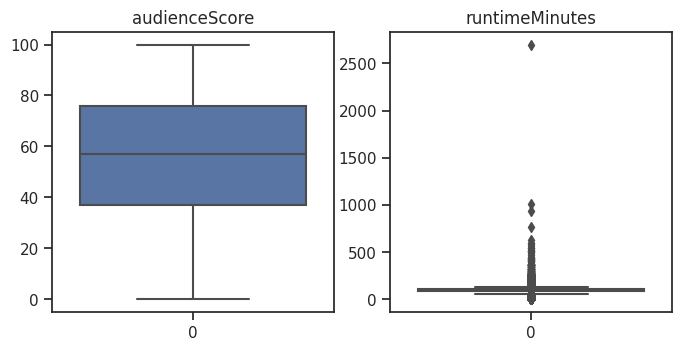

In [41]:
# Outliers Identification in Numerical Features

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(221)
ax.title.set_text('audienceScore')
sns.boxplot(data=movies_data['audienceScore'])

ax = fig.add_subplot(222)
ax.title.set_text('runtimeMinutes')
sns.boxplot(data=movies_data['runtimeMinutes'])

plt.show()

audienceScore doesn't have any outliers that drastically introduces any skewage of data whereas runtimeMinutes does from the above plot.

* Hence we use the standard textbook method of finding inter quartile range and removing outliers on either sides of the spectrum

In [42]:
# Calculating the IQR for 'runtimeMinutes'
Q1 = movies_data['runtimeMinutes'].quantile(0.25)
Q3 = movies_data['runtimeMinutes'].quantile(0.75)
IQR = Q3 - Q1

# Defining the threshold for outlier removal (1.5 times the IQR)
threshold = 1.5

# Removing rows with outlier values
movies_data = movies_data.loc[abs(movies_data['runtimeMinutes'] - Q1) <= threshold * IQR]

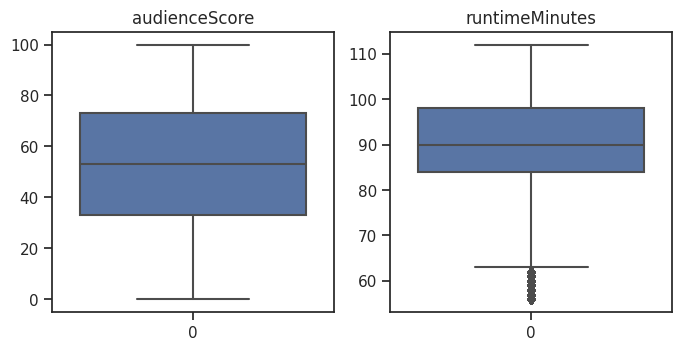

In [43]:
#Plotting the graphs for visual confirmation
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(221)
ax.title.set_text('audienceScore')
sns.boxplot(data=movies_data['audienceScore'])

ax = fig.add_subplot(222)
ax.title.set_text('runtimeMinutes')
sns.boxplot(data=movies_data['runtimeMinutes'])

plt.show()

Numerical columns, 'audienceScore' and 'runtimeMinutes' have 70010 and 129267 missing values which needs to be imputed and scaled in order to proceed with feature extraction

Imputation of missing values is a standard operating procedure due to following reasons :

* In real-world scenarios, missing data is common. Allows the model to make predictions even when complete information is not available for each single row.

*  Imputing missing values allows us to keep the structure of the dataset intact. Removing rows with missing data could disrupt the relationships and patterns present in the data.

* Most machine learning algorithms require complete data to work effectively. Without imputation, you might not be able to train a model at all if it is not imputed with optimal values or with empty strings, or it could lead to biased and inaccurate predictions.

It is also appropriate to scale these numerical features with MinMaxScaler.

```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

* Scaling features can prevent some features from dominating others in the regularization process.

* Scaling can make model coefficients or feature importances more interpretable. Without scaling, coefficients can be misleading, especially if features have very different scales.

* Having features on a similar scale helps the optimization process for the models we use during classification to converge more quickly and efficiently.

In [44]:
# Numerical columns: 'audienceScore' and 'runtimeMinutes'
numerical_columns = ['audienceScore', 'runtimeMinutes']

# Initializing IterativeImputer with appropriate parameters
numerical_imputer = IterativeImputer(max_iter=10, random_state=42)

# Fit and transform the numerical columns using IterativeImputer
movies_data[numerical_columns] = numerical_imputer.fit_transform(movies_data[numerical_columns])

# filling missing data with empty string before I send it for scaling
movies_data = movies_data.fillna('')

# Initializing the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the numerical columns using MinMaxScaler
movies_data[numerical_columns] = scaler.fit_transform(movies_data[numerical_columns])

# Rounding off the 'audienceScore' and 'runtimeMinutes' to the nearest integer
movies_data['audienceScore'] = movies_data['audienceScore'].round(decimals=2)
movies_data['runtimeMinutes'] = movies_data['runtimeMinutes'].round(decimals=2)

 Since the movies dataset encapsules Genre for each individual movieid (which has its corresponding genre available)

 * We calculate the frequency of each genre using value_counts() on the 'genre' column of the movies_data

 * Defining a threshold count (in this case, 5000 since top 5 genres have count of more than 5000, evidence provided in visualization section where the value genre count is used to plot a graph of counts) to determine which genres are considered 'Popular.'

Trying out feature engineering, where I derive a new feature based on existing data. The new 'popularity' feature captures an aspect of genre popularity based on the provided threshold.

Feature engineering can significantly impact the performance of machine learning models by providing them with more relevant and informative input.

In [45]:
# Using categorical column 'genre' here for building a new feature
genre_counts = movies_data['genre'].value_counts()

# Setting the threshold to classify genres as popular or less common
threshold = 5000

# Creating a new categorical feature 'popularity' indicating the type as 'popular' or 'less common' genre
movies_data['popularity'] = movies_data['genre'].apply(lambda x: 'Popular' if genre_counts[x] >= threshold else 'Less Common')

Resetting the index helps clear out any old, messy index and keeps everything in line. This keeps us from running into problems later, especially when we're working with the data or putting different pieces together.

After resetting, I create a copies of the two datasets on which we perform further complex operations and to have a save state from which we can always start from.

In [46]:
movies_data = movies_data.reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

d1 = train_data.copy()
d2 = movies_data.copy()

Grouping the data by 'movieid' helps us organize things better. The dataset has duplicate rows with unique information. This prevents us from dropping these valuable information.

We gather information like the
* title
* average audience score, average runtime
    * since there are more than one row with same movieid and different audience score and runtime minutes, we take the mean across all of them combined.
* combined genres
    * since there are more than one row with same movieid and different genres, we combine all the mentioned genres across duplicate rows.
* original language, director, and popularity.

This way, we combine the two sets of information, keeping everything linked and connected.

In [47]:
# Grouping the data by 'movieid' and aggregating other columns
aggregated_data = d2.groupby('movieid', as_index=False).agg({
    'title': 'first',
    'audienceScore': 'mean',
    'runtimeMinutes': 'mean',
    'genre': ','.join,
    'originalLanguage': 'first',
    'director': 'first',
    'popularity': 'last'
})

# Merging the datasets based on the 'movieid' column
merged_df = pd.merge(d1, aggregated_data, on='movieid', how='left')

We feature engineer another column called reviewTextLength which encapsulates the length count of the particular column's reviewText

* Since it is numerical feature we are engineering, it needs to be imputed and scaled accordingly.

In [48]:
# Convert 'reviewText' column to strings and compute review text length
merged_df['reviewTextLength'] = merged_df['reviewText'].astype(str).apply(len)

numerical_columns = ['audienceScore', 'runtimeMinutes', 'reviewTextLength']

# Initializing IterativeImputer with appropriate parameters
numerical_imputer = IterativeImputer(max_iter=10, random_state=42)

# Fit and transform the numerical columns using IterativeImputer
merged_df[numerical_columns] = numerical_imputer.fit_transform(merged_df[numerical_columns])

# filling missing data with empty string before I send it for scaling
merged_df = merged_df.fillna('')

# Initializing the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the numerical columns using MinMaxScaler
merged_df[numerical_columns] = scaler.fit_transform(merged_df[numerical_columns])

# Rounding off the 'audienceScore', 'runtimeMinutes' and 'reviewTextLength' to the nearest integer
merged_df['audienceScore'] = merged_df['audienceScore'].round(decimals=2)
merged_df['runtimeMinutes'] = merged_df['runtimeMinutes'].round(decimals=2)
merged_df['reviewTextLength'] = merged_df['reviewTextLength'].round(decimals=2)

Another set of Feature Engineering with breakup :

* Taking the 'popularity' column and turning it into binary values. If a movie is popular, I'll mark it with a +1, and if it's not so popular, 0.

* Then, I have this 'isFrequentReviewer' column that's in a True/False format. I'm converting it into binary. True becomes +1, and False becomes 0.

* Now, I am combining numerical columns together by adding up values from 'audienceScore', 'runtimeMinutes', 'popularity', 'isFrequentReviewer', and 'reviewTextLength'. This gives me a single combined numerical value for each row.

* After that, I scale the newly created column 'combined_numerical' so they're all within a certain range, making them easier to work with.

* Finding the average of 'combined_numerical'.

* Creating a new column called 'combined_binary' by checking if 'combined_numerical' is greater than the average I found earlier. If it is, I'll mark it as +1, and if not, 0.

In [49]:
# Convert 'popularity' to binary values (popular = +1, less popular = 0)
merged_df['popularity'] = merged_df['popularity'].apply(lambda x: 1 if x == 'Popular' else 0)

# Convert 'isFrequentReviewer' to binary values (True = +1, False = 0)
merged_df['isFrequentReviewer'] = merged_df['isFrequentReviewer'].astype(int)

# Combine numerical columns
merged_df['combined_numerical'] = merged_df['audienceScore'] + merged_df['runtimeMinutes'] + merged_df['popularity'] + merged_df['isFrequentReviewer'] + merged_df['reviewTextLength']

# Fit and transform the numerical columns using MinMaxScaler
scaler = MinMaxScaler()
merged_df['combined_numerical'] = scaler.fit_transform(merged_df['combined_numerical'].values.reshape(-1, 1))

# Calculate the mean of the combined_numerical column
mean_combined_numerical = merged_df['combined_numerical'].mean()

# Rounding off 'combined_numerical' to the nearest integer
merged_df['combined_numerical'] = merged_df['combined_numerical'].round(decimals=3)

# Update the combined_binary column based on the mean
merged_df['combined_binary'] = merged_df['combined_numerical'].apply(lambda x: 1 if x > mean_combined_numerical else 0)

Noting for anymore missing values in the dataset

In [50]:
missing_values_count_merged_df = merged_df.isnull().sum()
print(missing_values_count_merged_df)

data = merged_df.copy()

movieid               0
reviewerName          0
isFrequentReviewer    0
reviewText            0
sentiment             0
title                 0
audienceScore         0
runtimeMinutes        0
genre                 0
originalLanguage      0
director              0
popularity            0
reviewTextLength      0
combined_numerical    0
combined_binary       0
dtype: int64


In [51]:
data

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,title,audienceScore,runtimeMinutes,genre,originalLanguage,director,popularity,reviewTextLength,combined_numerical,combined_binary
0,marvelous_pirate,Benjamin Henry,0,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,Marvelous Pirate,0.65,0.88,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,0,0.25,0.326,0
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,0,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,Tony Montana Frodo Baggins V Rocky Balboa,0.52,0.62,Action,English,Alma White,0,0.46,0.284,0
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,1,Creed II does not give us anything but another...,POSITIVE,,0.60,0.71,,,,0,0.38,0.538,1
3,lara_croft_glimmer,Ryan Barrett,0,"I know what you're thinking, but this is no Li...",POSITIVE,Lara Croft Glimmer,0.47,0.57,"Action, Mystery & thriller, Sci-fi",English,Gail Pugh,0,0.58,0.289,0
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,0,Director Fernando Meirelles tells the story wi...,POSITIVE,,0.60,0.71,,,,0,0.42,0.315,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,0,A top-notch thriller with genuine surprises an...,POSITIVE,The Joker Ethereal Captain Jack Sparrow Fantastic,0.45,0.69,"Romance,Mystery & thriller, Comedy,Crime, Dram...",English,Gertrude Fonner,1,0.23,0.464,1
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,1,Some people find Derek Zoolander funny and lik...,NEGATIVE,E.T. Hannibal Lecter Vito Corleone Katniss Eve...,0.20,0.82,"Comedy, Adventure",English,Susan Oley,0,0.30,0.452,1
162755,infinite_enigma_luke_skywalker,Bryan Wilson,0,"This fun, gentle comedy focuses mainly on them...",POSITIVE,Infinite Enigma Luke Skywalker,0.78,0.61,"Comedy, Drama",English,Bryant Reams,0,0.51,0.354,0
162756,emerald_oracle_iron_man_wolverine,Erik Parker,0,"The film is rescued by a strong third act, but...",NEGATIVE,Emerald Oracle Iron Man Wolverine,0.39,0.57,"Kids & family, Holiday, Comedy",English,Lisa Cruz,0,0.21,0.184,0


# Visualization of key statistics and relationships

<Figure size 1000x800 with 0 Axes>

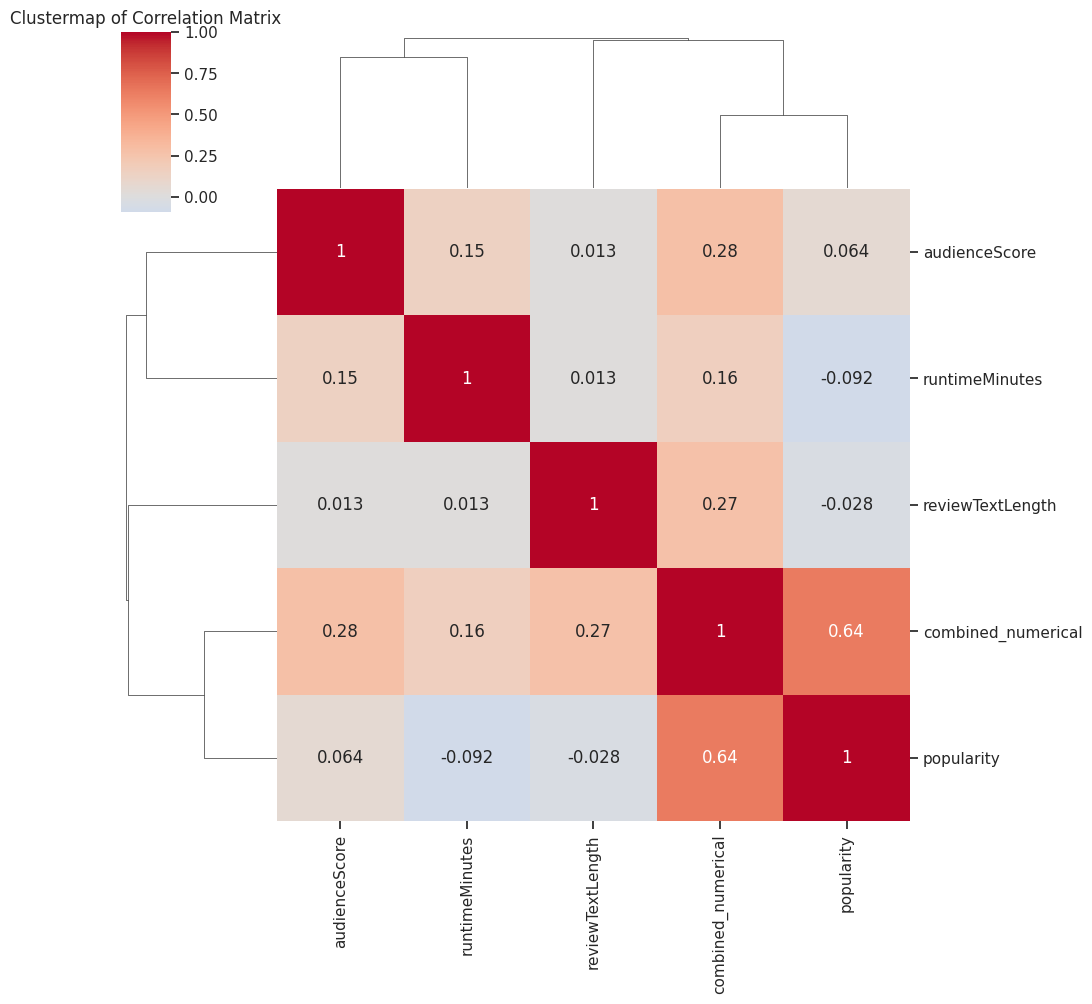

In [52]:
# Define the numerical columns you want to include
numeric_columns = ['audienceScore', 'combined_numerical', 'runtimeMinutes', 'reviewTextLength', 'popularity']

# Create a figure and set the size
plt.figure(figsize=(10, 8))

# Compute the correlation matrix
correlation_matrix = data[numeric_columns].corr()

# Create a clustered heatmap of the correlation matrix
sns.clustermap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Set the plot title
plt.title('Clustermap of Correlation Matrix')

# Display the plot
plt.show()

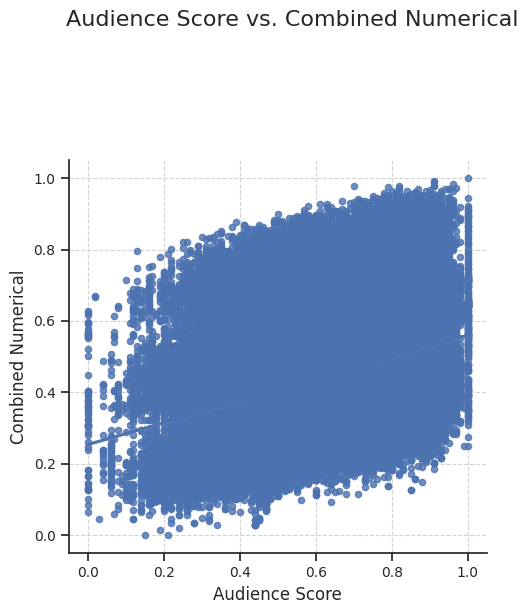

In [53]:
sns.set(style="ticks")
plot = sns.jointplot(x='audienceScore', y='combined_numerical', data=data, kind='reg', scatter_kws={'s': 20}, height=6)
plot.fig.suptitle('Audience Score vs. Combined Numerical', fontsize=16, y=1.02)
plot.set_axis_labels('Audience Score', 'Combined Numerical', fontsize=12)

# Set ticks and grid lines
plot.ax_joint.yaxis.grid(True)
plot.ax_joint.xaxis.grid(True)

# Adjust tick label font sizes
plot.ax_joint.tick_params(axis='both', which='major', labelsize=10)

# Remove the redundant right-top plot
plot.ax_joint.spines['top'].set_visible(False)
plot.ax_joint.spines['right'].set_visible(False)

# Add a subtle background grid for better readability
plot.ax_joint.yaxis.grid(color='lightgray', linestyle='--', linewidth=0.8)
plot.ax_joint.xaxis.grid(color='lightgray', linestyle='--', linewidth=0.8)

# Remove the individual histogram plots on the right and top
plot.ax_marg_x.remove()
plot.ax_marg_y.remove()

plt.tight_layout()
plt.show()

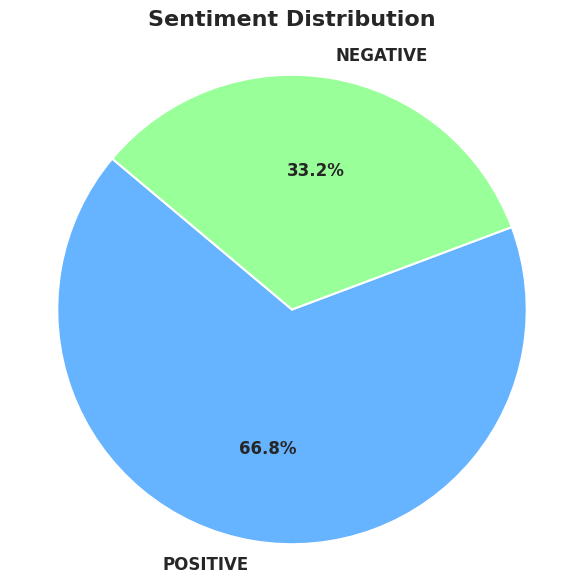

In [54]:
sentiment_counts = data['sentiment'].value_counts()

# Define colors for the pie chart
colors = ['#66b3ff', '#99ff99']

# Create a figure and axis with equal aspect ratio
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")

# Pie chart for sentiment distribution
wedges, texts, autotexts = ax.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)

# Beautify labels and autotexts
for text in texts + autotexts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

# Add shadow for a subtle 3D effect
for wedge in wedges:
    wedge.set_edgecolor('white')
    wedge.set_linewidth(1.5)

# Set title with larger font size and elegant alignment
ax.set_title('Sentiment Distribution', fontsize=16, pad=20, fontweight='bold')

# Equal aspect ratio ensures the pie chart looks circular
ax.axis('equal')

# Remove y-axis labels and ticks for a clean appearance
ax.set_yticks([])
ax.set_ylabel("")

# Display the plot with tight layout for optimal spacing
plt.tight_layout()

# Show the plot
plt.show()

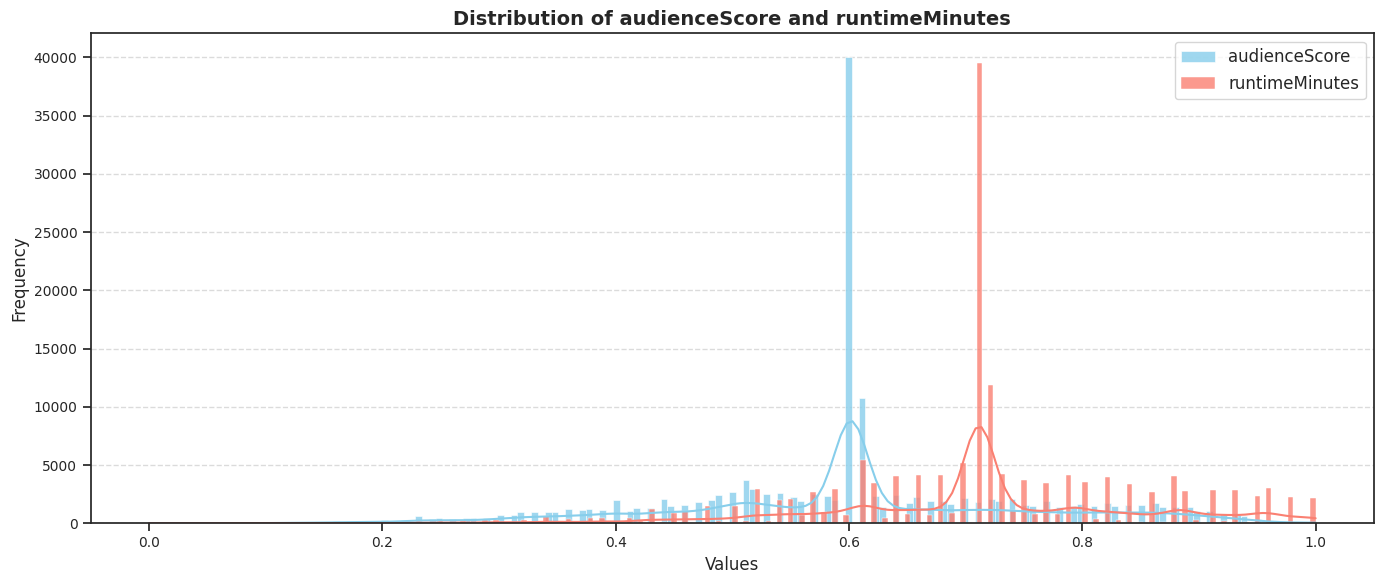

In [55]:
# Numerical columns: 'audienceScore', and 'runtimeMinutes'
numerical_columns = ['audienceScore', 'runtimeMinutes']

# Defining different colors for each numerical feature
colors = ['skyblue', 'salmon']

# Visualizing numerical features using histograms
plt.figure(figsize=(14, 6))
for i, col in enumerate(numerical_columns):
    sns.histplot(data[col], kde=True, label=col, color=colors[i], alpha=0.8)
plt.xlabel('Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of audienceScore and runtimeMinutes', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

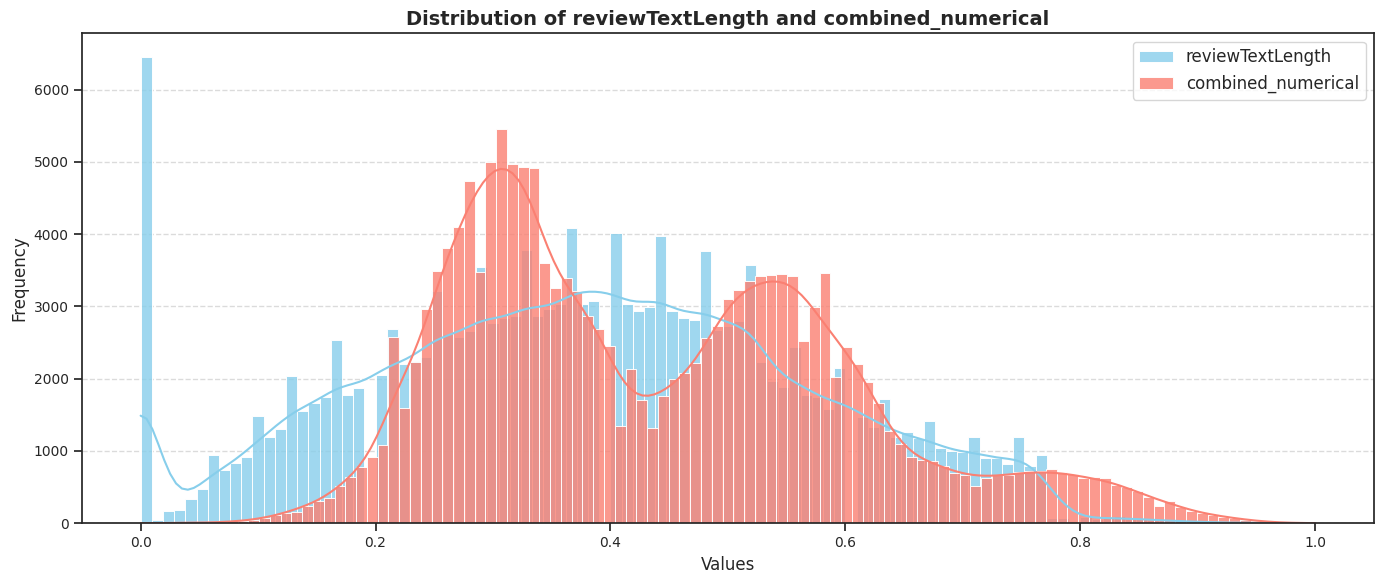

In [56]:
# Numerical columns: 'reviewTextLength' and 'combined_numerical'
numerical_columns = ['reviewTextLength', 'combined_numerical']

# Visualizing numerical features using histograms
plt.figure(figsize=(14, 6))
for i, col in enumerate(numerical_columns):
    sns.histplot(data[col], kde=True, label=col, color=colors[i], alpha=0.8)
plt.xlabel('Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of reviewTextLength and combined_numerical', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

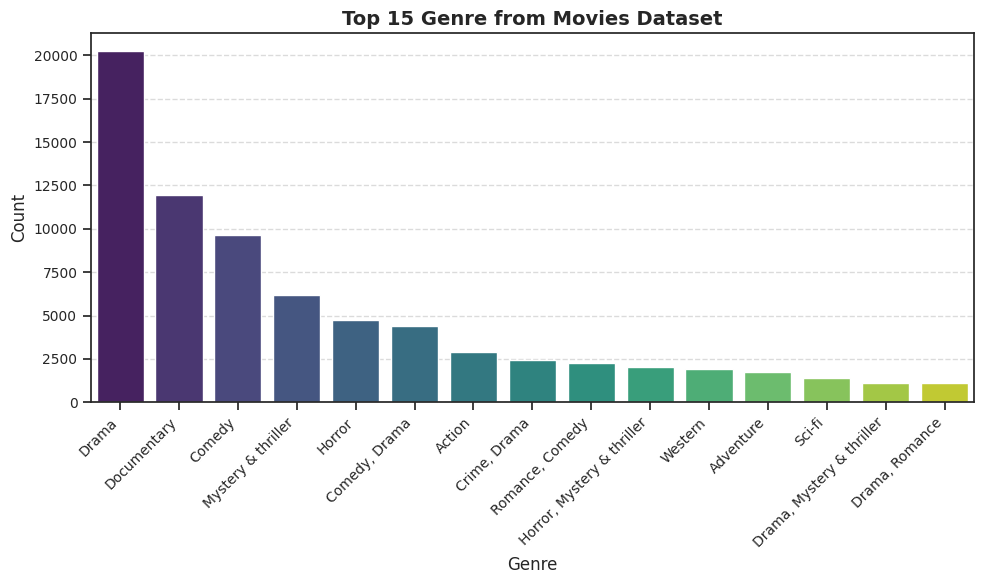

In [57]:
# Categorical column: 'genre'
genre_counts = movies_data['genre'].value_counts()

# Get the top 15 most frequent genre names
top_15_genres = genre_counts.head(15)

# Plotting the top 10 genres and their counts
plt.figure(figsize=(10, 6))
sns.barplot(x=top_15_genres.index, y=top_15_genres.values, palette='viridis')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Top 15 Genre from Movies Dataset', fontsize=14, fontweight='bold')
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

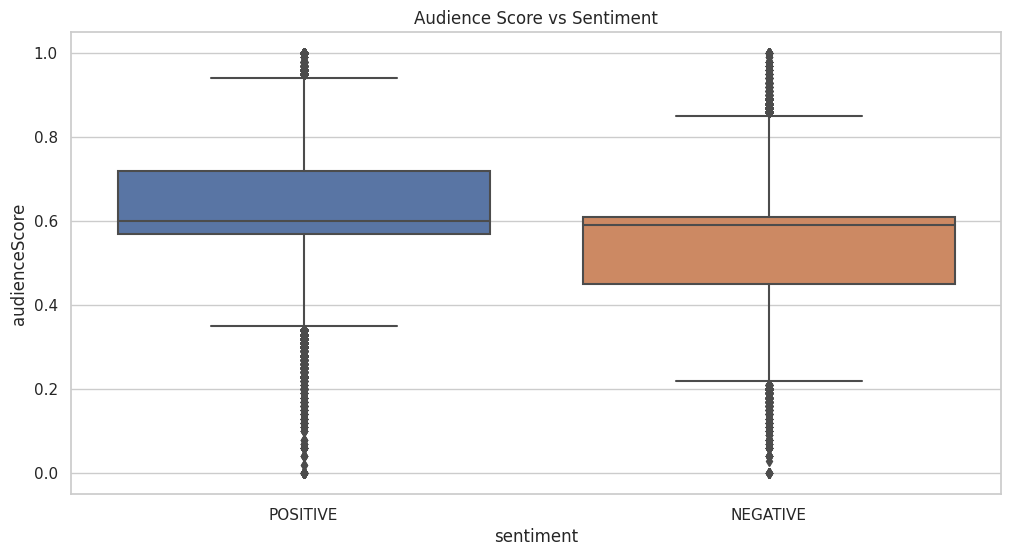

In [58]:
# Setting up Seaborn style
sns.set(style="whitegrid")

# Box Plot for 'audienceScore' vs. Sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='audienceScore', data=data)
plt.title('Audience Score vs Sentiment')
plt.show()

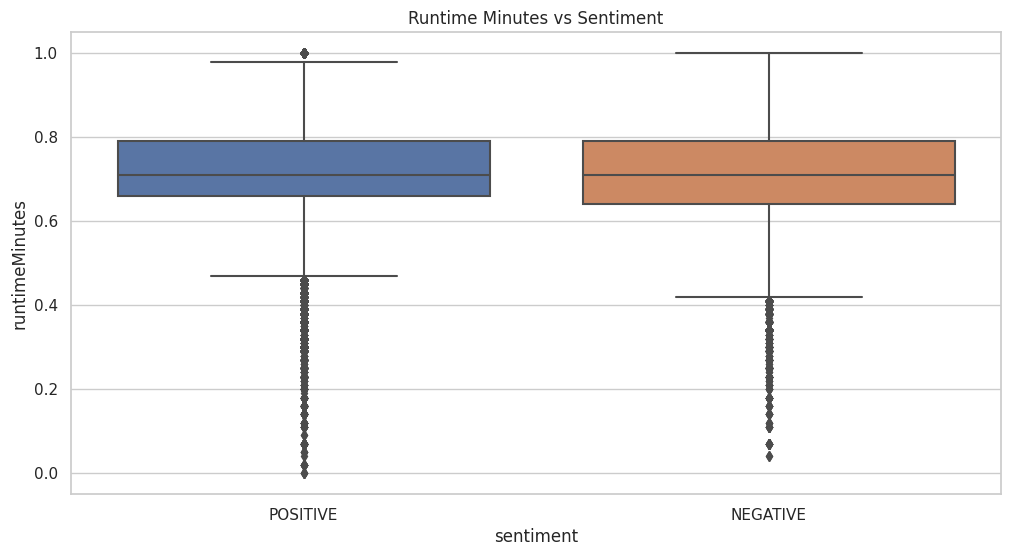

In [59]:
# Box Plot for 'runtimeMinutes' vs. Sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='runtimeMinutes', data=data)
plt.title('Runtime Minutes vs Sentiment')
plt.show()

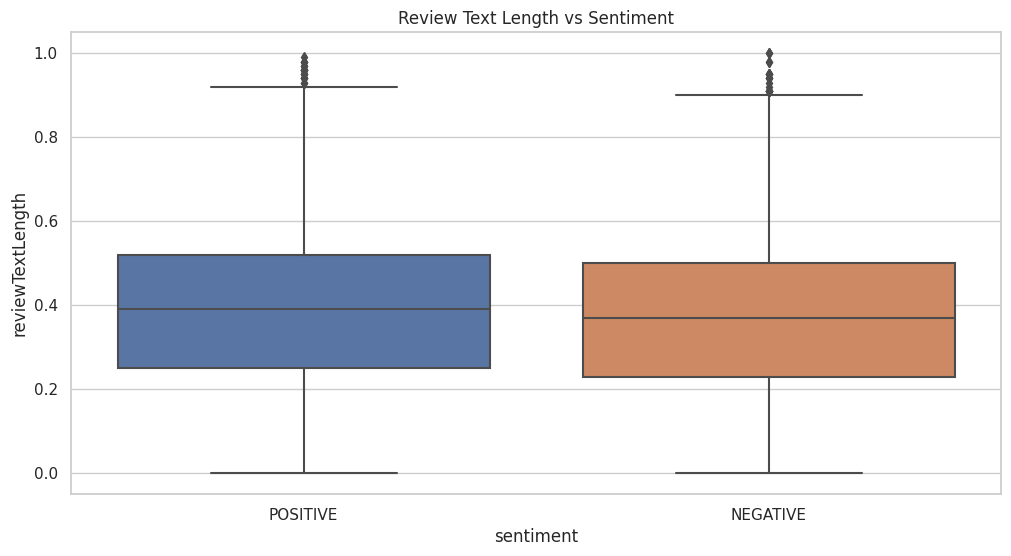

In [60]:
# Box Plot for Review Text Length vs Sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='reviewTextLength', data=data)
plt.title('Review Text Length vs Sentiment')
plt.show()

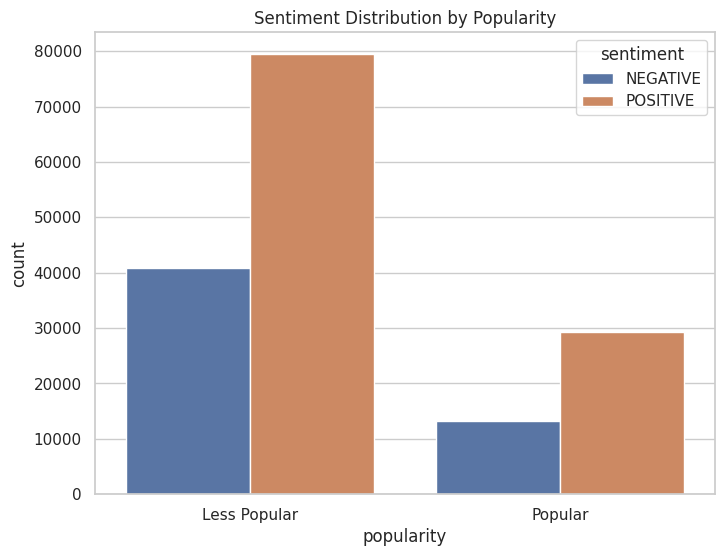

In [61]:
# Bar Plot for Popularity vs. Sentiment
plt.figure(figsize=(8, 6))
sns.barplot(x='popularity', y='count', hue='sentiment', data=data.groupby(['popularity', 'sentiment']).size().reset_index(name='count'))
plt.title('Sentiment Distribution by Popularity')
plt.xticks(ticks=[0, 1], labels=['Less Popular', 'Popular'])
plt.show()

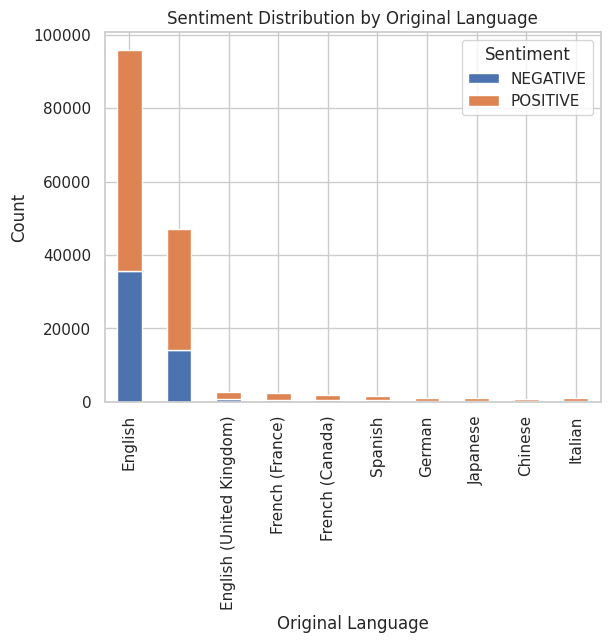

In [62]:
# A pivot table to show sentiment distribution by original language
pivot_table_original_language = pd.pivot_table(data, index='originalLanguage', columns='sentiment', aggfunc='size', fill_value=0)

# Plotting the pivot table as a stacked bar plot
pivot_table_original_language.sort_values(by='POSITIVE', ascending=False).head(10).plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Original Language')
plt.xlabel('Original Language')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

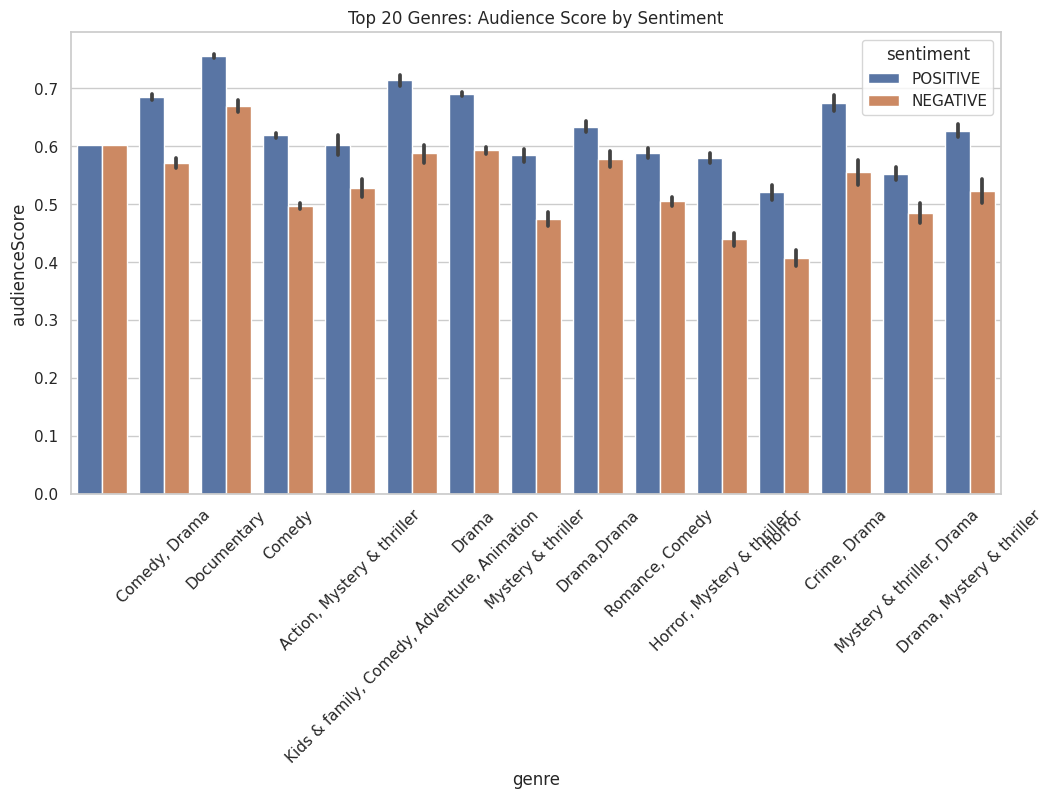

In [63]:
# Bar Plot for Top 20 Categorical Features vs. Sentiment
top_genres = data['genre'].value_counts().head(15).index
data_top_genres = data[data['genre'].isin(top_genres)]

plt.figure(figsize=(12, 6))
sns.barplot(x='genre', y='audienceScore', hue='sentiment', data=data_top_genres)
plt.title('Top 20 Genres: Audience Score by Sentiment')
plt.xticks(rotation=45)
plt.show()
print('\n')

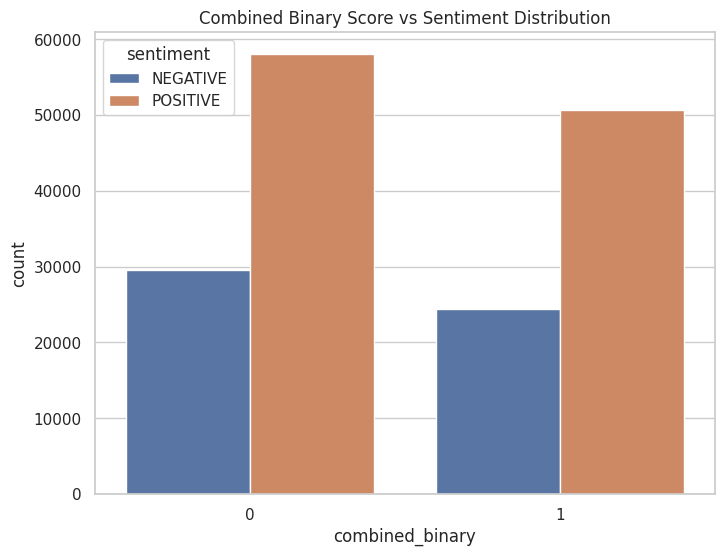

In [64]:
# Bar Plot for 'combined_binary' vs. Sentiment
plt.figure(figsize=(8, 6))
sns.barplot(x='combined_binary', y='count', hue='sentiment', data=data.groupby(['combined_binary', 'sentiment']).size().reset_index(name='count'))
plt.title('Combined Binary Score vs Sentiment Distribution')
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.show()

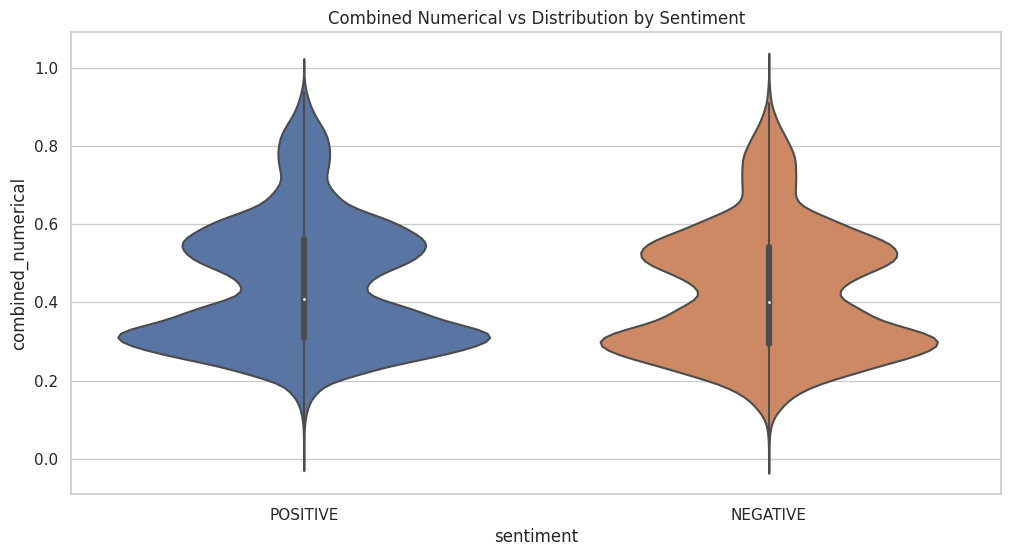

In [65]:
# Violin Plot for 'combined_numerical' vs. sentiment
plt.figure(figsize=(12, 6))
sns.violinplot(x='sentiment', y='combined_numerical', data=data)
plt.title('Combined Numerical vs Distribution by Sentiment')
plt.show()

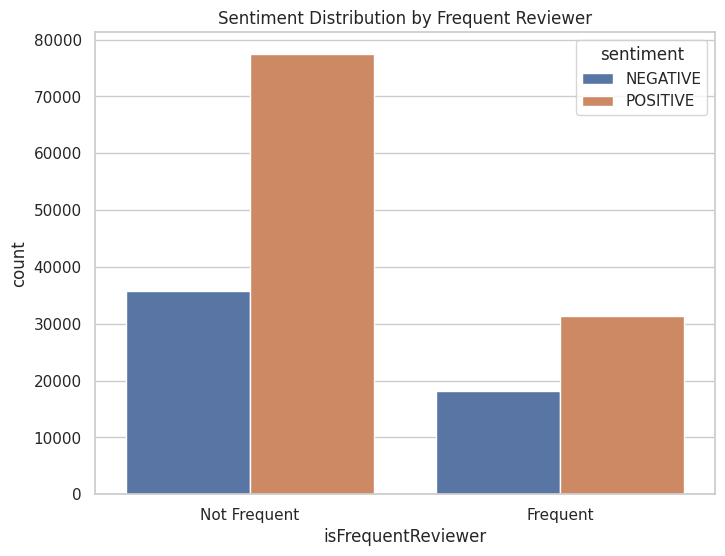

In [66]:
# Bar Plot for Frequent Reviewer vs. Sentiment
plt.figure(figsize=(8, 6))
sns.barplot(x='isFrequentReviewer', y='count', hue='sentiment', data=data.groupby(['isFrequentReviewer', 'sentiment']).size().reset_index(name='count'))
plt.title('Sentiment Distribution by Frequent Reviewer')
plt.xticks(ticks=[0, 1], labels=['Not Frequent', 'Frequent'])
plt.show()

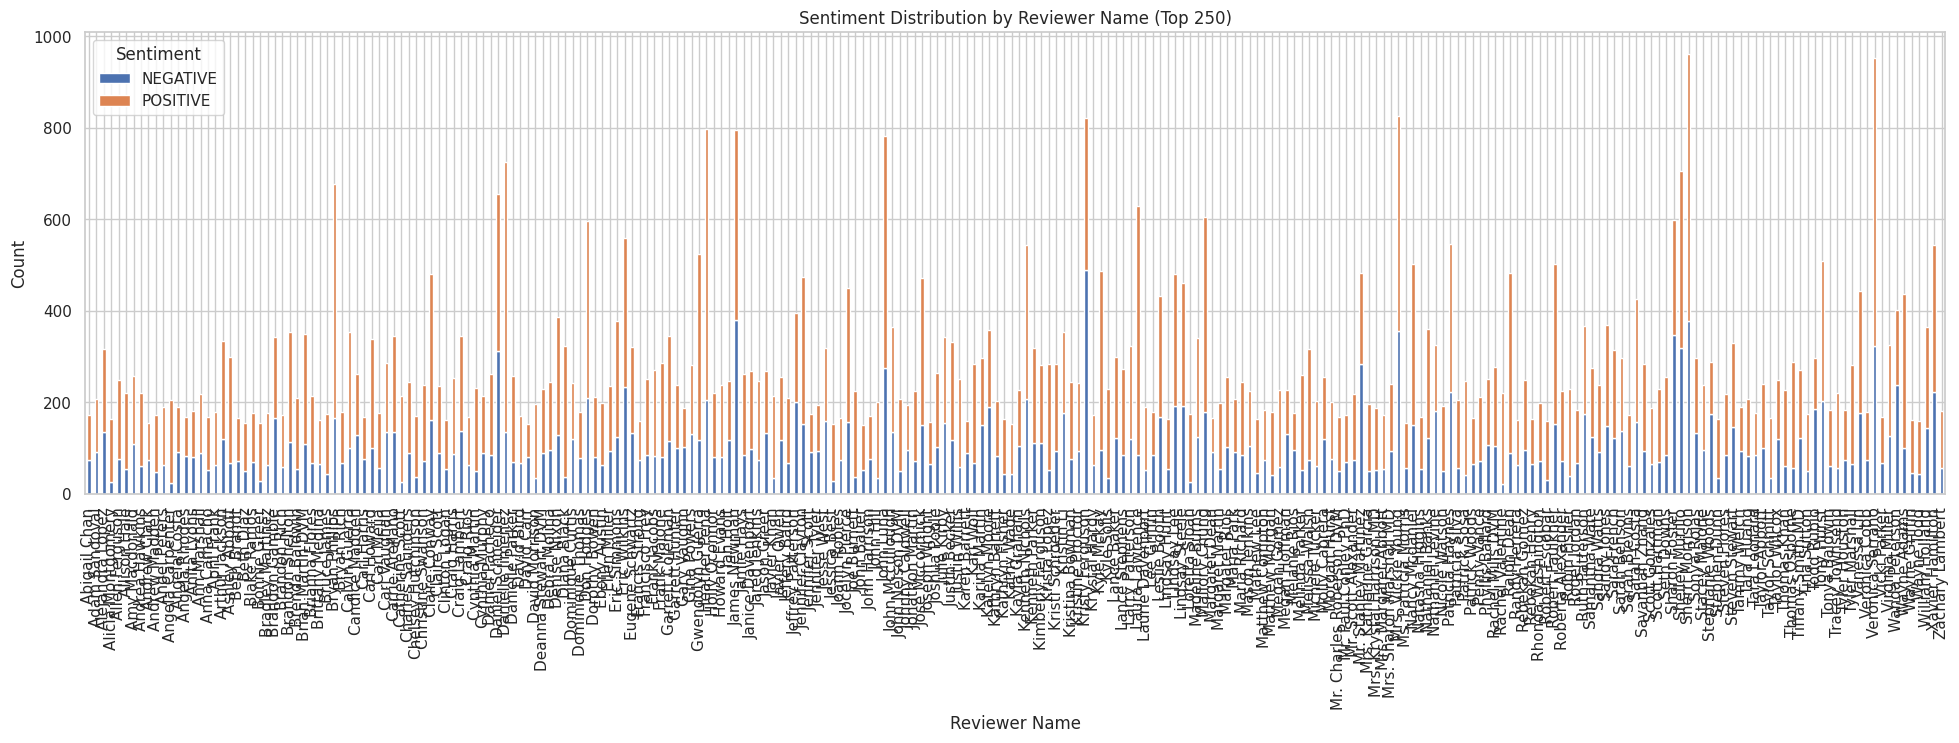

In [67]:
# Filtering the top 250 reviewer names
top_250_reviewers = data['reviewerName'].value_counts().head(250).index
data_top_250_reviewers = data[data['reviewerName'].isin(top_250_reviewers)]

# Pivot table to show sentiment distribution by reviewer name
pivot_table_reviewer_name = pd.pivot_table(data_top_250_reviewers, index='reviewerName', columns='sentiment', aggfunc='size', fill_value=0)

# Plotting the pivot table as a stacked bar plot
pivot_table_reviewer_name.plot(kind='bar', stacked=True, figsize=(24, 6))
plt.title('Sentiment Distribution by Reviewer Name (Top 250)')
plt.xlabel('Reviewer Name')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Sentiment')

plt.show()

# Exploratory data analysis

Basic information about the datasets

In [68]:
train_data.shape

(162758, 5)

In [69]:
movies_data.shape

(103454, 8)

In [70]:
data.shape

(162758, 15)

In [71]:
print(train_data.info())
print('\n')

print(train_data.describe())
print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB
None


                                            movieid     reviewerName  \
count                                        162758           162758   
unique                                        16812             4482   
top     escape_the_terminator_tyler_durden_astonish  Sherri Morrison   
freq                                            708              962   

       isFrequentReviewer               reviewText sentiment  
count              162758                   156311    162758  
uniq

In [72]:
print(movies_data.info())
print('\n')

print(movies_data.describe())
print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103454 entries, 0 to 103453
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   movieid           103454 non-null  object 
 1   title             103454 non-null  object 
 2   audienceScore     103454 non-null  float64
 3   runtimeMinutes    103454 non-null  float64
 4   genre             103454 non-null  object 
 5   originalLanguage  103454 non-null  object 
 6   director          103454 non-null  object 
 7   popularity        103454 non-null  object 
dtypes: float64(2), object(6)
memory usage: 6.3+ MB
None


       audienceScore  runtimeMinutes
count  103454.000000   103454.000000
mean        0.521754        0.608076
std         0.182712        0.208727
min         0.000000        0.000000
25%         0.460000        0.500000
50%         0.520000        0.610000
75%         0.570000        0.750000
max         1.000000        1.000000




In [73]:
print(data.info())
print('\n')

print(data.describe())
print('\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movieid             162758 non-null  object 
 1   reviewerName        162758 non-null  object 
 2   isFrequentReviewer  162758 non-null  int64  
 3   reviewText          162758 non-null  object 
 4   sentiment           162758 non-null  object 
 5   title               162758 non-null  object 
 6   audienceScore       162758 non-null  float64
 7   runtimeMinutes      162758 non-null  float64
 8   genre               162758 non-null  object 
 9   originalLanguage    162758 non-null  object 
 10  director            162758 non-null  object 
 11  popularity          162758 non-null  int64  
 12  reviewTextLength    162758 non-null  float64
 13  combined_numerical  162758 non-null  float64
 14  combined_binary     162758 non-null  int64  
dtypes: float64(4), int64(3), object(8)

In [74]:
print(test_data.info())
print('\n')

print(test_data.describe())
print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB
None


                                            movieid     reviewerName  \
count                                         55315            55315   
unique                                        16786             4495   
top     escape_the_terminator_tyler_durden_astonish  Sherri Morrison   
freq                                            230              428   

       isTopCritic               reviewText  
count        55315                    52805  
unique           2                    52686  
top          False  Parental Content Review  
freq         38428                     

Sentiment Distribution

In [75]:
sentiment_distribution = data['sentiment'].value_counts(normalize=True)

# Print sentiment distribution
print("Sentiment Distribution:\n", sentiment_distribution)
print('\n')

Sentiment Distribution:
 POSITIVE    0.668238
NEGATIVE    0.331762
Name: sentiment, dtype: float64




Impact of numeric features on sentiment

In [76]:
numeric_features = ['audienceScore', 'runtimeMinutes', 'popularity', 'combined_numerical']
numeric_impact = data.groupby('sentiment')[numeric_features].mean()
print("Impact of Numeric Features on Sentiment:\n", numeric_impact)
print('\n')

Impact of Numeric Features on Sentiment:
            audienceScore  runtimeMinutes  popularity  combined_numerical
sentiment                                                               
NEGATIVE        0.545018        0.715291    0.244717            0.426438
POSITIVE        0.631768        0.712579    0.269646            0.444804




'frequent reviewers' impact on sentiment

In [77]:
freq_reviewer_sentiment = data.groupby('isFrequentReviewer')['sentiment'].value_counts(normalize=True)
print("Sentiment Distribution by Frequent Reviewer:\n", freq_reviewer_sentiment)
print('\n')

Sentiment Distribution by Frequent Reviewer:
 isFrequentReviewer  sentiment
0                   POSITIVE     0.684068
                    NEGATIVE     0.315932
1                   POSITIVE     0.632089
                    NEGATIVE     0.367911
Name: sentiment, dtype: float64




'combined_binary' impact on sentiment

In [78]:
combined_binary_sentiment = data.groupby('combined_binary')['sentiment'].value_counts(normalize=True)
print("Sentiment Distribution by combined_binary:\n", combined_binary_sentiment)
print('\n')

Sentiment Distribution by combined_binary:
 combined_binary  sentiment
0                POSITIVE     0.662692
                 NEGATIVE     0.337308
1                POSITIVE     0.674706
                 NEGATIVE     0.325294
Name: sentiment, dtype: float64




'directors' impact on sentiment

In [79]:
director_sentiment = data.groupby('director')['sentiment'].value_counts(normalize=True, sort=True)
print("Sentiment Distribution by Director:\n", director_sentiment)

Sentiment Distribution by Director:
 director      sentiment
              POSITIVE     0.703914
              NEGATIVE     0.296086
Aaron Amato   POSITIVE     0.650000
              NEGATIVE     0.350000
Aaron Beal    POSITIVE     1.000000
                             ...   
Zoe Johnson   NEGATIVE     1.000000
Zoe King      POSITIVE     1.000000
Zofia Denny   POSITIVE     1.000000
Zula Russell  POSITIVE     0.809524
              NEGATIVE     0.190476
Name: sentiment, Length: 13652, dtype: float64


Top 10 genres vs Sentiment Count

In [80]:
# Filter out the top 10 genres
top_10_genres = data['genre'].value_counts().head(10).index
data_top_10_genres = data[data['genre'].isin(top_10_genres)]

# Creating a pivot table to show the distribution of sentiment counts for each genre
pivot_table = pd.pivot_table(data_top_10_genres, index='genre', columns='sentiment', aggfunc='size', fill_value=0)

# Calculating the correlation between positive and negative sentiment counts for each genre
correlation = pivot_table['POSITIVE'].corr(pivot_table['NEGATIVE'])

# Display the pivot table and correlation
print("Sentiment Counts by Genre:")
print(pivot_table)
print("\nCorrelation between Positive and Negative Sentiment Counts:", correlation)

Sentiment Counts by Genre:
sentiment                                    NEGATIVE  POSITIVE
genre                                                          
                                                13749     32686
Comedy                                           3976      4624
Comedy, Drama                                    1661      4196
Documentary                                      1003      5998
Drama                                            2795      8415
Horror                                            681       915
Horror, Mystery & thriller                       1167      1700
Kids & family, Comedy, Adventure, Animation       365       905
Mystery & thriller                                869      1326
Romance, Comedy                                  1495      1445

Correlation between Positive and Negative Sentiment Counts: 0.9729510187966629


# Important insights or findings

**Visual Insights:**

**Auxiliary Movies Dataset Insights:**

1. **Correlation Matrix Clustermap:** The correlation analysis of numerical features using a clustermap indicates the dominance of `popularity` within the engineered feature `combined_numerical`. It's evident that `popularity` wields the highest influence among the variables.

2. **Linear Relationship Visualization:** The regression line in the joint plot reveals a direct linear relationship between `audienceScore` and `combined_numerical`. The majority of data points exhibit a proportional trend between these two features.

3. **Sentiment Distribution:** The sentiment distribution plot showcases the composition of positive and negative sentiments in the training dataset, with approximately 66.8% being positive and 33.2% being negative.

4. **Scaled Numerical Features:** Utilizing MinMaxScaler for numerical features, the graph portraying `audienceScore` against `runtimeMinutes` depicts a right-skewed pattern. This skewedness centers around 0.6 for `audienceScore` and 0.75 for `runtimeMinutes`.

5. **Relationship in Histogram Plot:** An overlapping histogram showcases the parallel relationship between `reviewTextLength` and `combined_numerical`. The peaks around 0.35 for `combined_numerical` and 0.4 to 0.5 for `reviewTextLength` reflect a direct proportionality due to the contribution of `reviewTextLength` to `combined_numerical`.

6. **Top Genre Bar Plot:** The bar plot of the top 15 genres by count underscores the dominance of Drama, Documentary, Comedy, Thriller, and Horror. This observation inspires the idea of labeling movies as 'Popular' or 'Less Popular' based on their genres.

7. **Original Language Sentiment:** A pivot table analyzing sentiment distribution across original languages reveals consistent sentiment ratios across languages, implying no discernible patterns for classification.

8. **Box Plots for Sentiment and Features:** Box plots for `audienceScore`, `runtimeMinutes`, and `reviewTextLength` vis-a-vis sentiment showcase consistent interquartile ranges for positive and negative sentiments, indicating limited or no correlation with these features.

9. **Popularity vs. Sentiment Bar Plot:** Comparing sentiment distribution with movie popularity, 'Popular' movies display a sentiment ratio of 1:2.5 (positive:negative), while 'Less Popular' movies exhibit a ratio of 1:2.

10. **Genre Distribution Bar Plot:** A bar plot analyzing genre distribution reveals a lack of unique sentiment patterns across genres, suggesting limited predictive value.

11. **Ineffectual Numerical Features:** Visualizations show that the engineered column `combined_numerical` and `combined_binary` do not offer significant variance across sentiments, making them less useful for predicting sentiment.

**Primary Training Dataset Insights:**

1. **`isFrequentReviewer` Influence:** A bar plot illustrates the differing sentiment ratios for `isFrequentReviewer`. Notably, true `isFrequentReviewers` have a positive:negative sentiment ratio of 1:1.66, while false ones exhibit a ratio of 1:2.22.

2. **Top Reviewer Sentiment Analysis:** Pivot analysis on the top 250 reviewers highlights varying sentiment contributions. Some reviewers consistently provide positive reviews, while others offer a mix of positive and negative ones. A few reviewers lean heavily toward negative reviews.

3. **`reviewText` as Key Feature:** With TFIDF vectorization, `reviewText` is a pivotal feature due to its abundant unique words. This promises richer information for each review, making it a potent predictor.

4. **Categorical Features:** `movieid` and `reviewerName` are key categorical features. The sheer number of unique `movieid` values suggests potential repetitions, indicating a need for EDA.

5. **Feature Selection:** Based on these insights, the classification model will incorporate `movieid`, `reviewerName`, and `isFrequentReviewer` as categorical features, along with `reviewText` as the pivotal text feature. The compatibility with the test dataset ensures seamless model deployment and prediction.

By meticulously examining these visualizations, discerning intricate relationships and patterns within the given datasets, The stage is set for an informed and effective machine learning model training process.

# Preprocessing

In [81]:
# Replacing missing values with an empty string in both datasets (Basic Imputation to get started)

train_data['reviewText'] = train_data['reviewText'].fillna('')
test_data['reviewText'] = test_data['reviewText'].fillna('')

**Preprocessing for training data**

1. Feature Extraction:
   - We're starting by pulling out the specific features we need from our `train_data` namely text data (`reviewText`), numeric data (`isFrequentReviewer`), and categorical data (`movieid` and `reviewerName`).

2. Numeric Feature Adjustment:
   - The `isFrequentReviewer` column is currently in True/False format, converting it into numeric values: 0 for False and 1 for True

3. Categorical Data Encoding:
   - Categorical columns like `movieid` and `reviewerName` need "one-hot encoding" to transform them into a format that's easier for the model to work with.
   - One-hot encoding transforms categorical data into a binary format (0 or 1) for better model understanding.

4. Text Data Transformation:
   - We're using "TF-IDF vectorization" on the `reviewText` column.
   -  It operates by calculating the frequency of words within a document (TF) and their rarity across all documents (IDF). The TF-IDF score for a word in a document is the product of its TF and IDF values, resulting in a vector representation. High score indicates rarity of a word in the dataset.

5. Feature Concatenation:
   - Since TFIDF vectors are often sparse, scipy.sparse.hstack is commonly used to efficiently concatenate them with other sparse matrices.
   - Using hstack from scipy.sparse to horizontally stack the transformed text data (X_text_tfidf_train), the numeric data (X_numeric_train), and the one-hot encoded categorical data (X_categorical_encoded_train) to create the training set X_train.

6. Target Variable Encoding:
   - The target variable is the `sentiment` column.
   - We're using "label encoding" to convert different sentiments into numerical values which helps the model to work with the target variable effectively.

In a nutshell, we're combining everything valuable into a format that our model can use to learn patterns and make predictions.

In [82]:
# Extracting the necessary features from train_data
X_text_train = train_data['reviewText']
X_numeric_train = train_data[['isFrequentReviewer']]
X_categorical_train = train_data[['movieid', 'reviewerName']]

# Converting 'isFrequentReviewer' from boolean to numeric (0 or 1)
X_numeric_train['isFrequentReviewer'] = X_numeric_train['isFrequentReviewer'].astype(int)

# Converting categorical columns to one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_categorical_encoded_train = onehot_encoder.fit_transform(X_categorical_train)

# Transforming text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1, lowercase=True)
X_text_tfidf_train = vectorizer.fit_transform(X_text_train)

# Concatenating the features for the training set
X_train = hstack((X_text_tfidf_train, X_numeric_train, X_categorical_encoded_train))

# Encoding target variable y
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_data['sentiment'])

**Preprocessing for test data**

Feature Extraction :
- Similar feature extraction is performed for the test_data set. Text data
 (`reviewText`), numeric data (`isTopCritic`), and categorical data (`movieid` and `reviewerName`) are extracted for further processing.

Numeric Feature Adjustment for Test Data :
- The numeric adjustment stage entails transforming the `isTopCritic` column from boolean to numeric representation (0 or 1) to match the format used in training.

Categorical Data Encoding for Test Data :
- The one-hot encoding process is extended to the categorical data extracted from the test_data set (`movieid` and `reviewerName`). The transformed categorical features are in alignment with those used during training.

Text Data Transformation for Test Data :
- Building upon the previously applied TF-IDF vectorization, the test_X_text_tfidf is derived by transforming the test_X_text data using the same vectorizer used in training.

Feature Concatenation for Test Data :
- Similar to the training process, the extracted and transformed features from the test set are concatenated using hstack to create the test set test_X. This aligns with the architecture of the training data set.

In [83]:
# Extracting features from test data
test_X_text = test_data['reviewText']
test_X_numeric = test_data[['isTopCritic']]
test_X_categorical = test_data[['movieid', 'reviewerName']]

# Converting 'isTopCritic' from boolean to numeric (0 or 1)
test_X_numeric['isTopCritic'] = test_X_numeric['isTopCritic'].astype(int)

test_X_categorical_encoded = onehot_encoder.transform(test_X_categorical)

# Transforming text data using the same TF-IDF vectorizer as in training
test_X_text_tfidf = vectorizer.transform(test_X_text)

# Concatenating the features for the test set
test_X = hstack((test_X_text_tfidf, test_X_numeric, test_X_categorical_encoded))

# Hyperparameter tuning

We use hyper parameter tuning on the best performing model to further improve model's accuracy by instantiated it with better parameters to begin with rather than a random state. This emphasizes proper model validation and exploration of model attributes.

1. Data Splitting
   - The dataset `X_train` and target variable `y` are split into training (`X_train_split`, `y_train_split`) and testing (`X_test_split`, `y_test_split`) sets using a 80-20 ratio.

2. Stratified K-Fold Cross-Validation
   - A Stratified K-Fold with 3 folds is initialized. It ensures that each fold maintains the same class distribution as the entire dataset, minimizing bias.

3. Hyperparameter Grid
   - A grid of hyperparameters for the Logistic Regression model is defined. This grid includes various settings for regularization, solver, class weights, etc.

4. Model Creation
   - A Logistic Regression model `classifier_who` is instantiated. It includes parameters for controlling iterations, warm starting, and convergence tolerance.

5. Grid Search with Cross-Validation
   - A GridSearchCV is performed using the defined hyperparameters, scoring metric (`f1_micro`), and cross-validation from the Stratified K-Fold. It searches for the best combination of hyperparameters.

6. Best Hyperparameters and F1 Score
   - The output displays the best hyperparameters and the corresponding F1 micro score, indicating the best performing combination of settings.

7. Model Training with Best Hyperparameters
   - A new Logistic Regression model `best_classifier` is created using the best hyperparameters found through the grid search. This model will be used for evaluation.

8. Trained Model Attributes
   - Various attributes of the trained `best_classifier` model are printed, including classes, coefficients, intercept, number of features seen during fit, and actual iterations taken.

9. Model Evaluation
   - The model is evaluated on the test set by making predictions (`y_pred`) and comparing them against the actual labels (`y_test_split`).

In [84]:
'''
# Splitting the data into training and testing sets for tuning
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y, test_size=0.2, random_state=42)

# Initializing Stratified K-Fold
num_folds = 3
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=77)

# Initializing a grid of hyperparameters for GridSearchCV
param_grid = {
    'C': [0.1, 0.8, 2, 5, 7, 8.01, 8.10, 10, 25, 100, 512],
    'solver': ['liblinear'],
    'multi_class': ['ovr'],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced'],
    'dual': [True, False],
    'fit_intercept': [True, False],
    'intercept_scaling': [0.1, 1, 10],
    'random_state': [42, 84],
}

# Creating a model (in this case a logistic regression since it is the top performing model according to evaluation metrics)
classifier_who = LogisticRegression(max_iter=500, warm_start=True, tol=1e-3)

# Performing grid search with cross-validation
grid_search = GridSearchCV(classifier_who, param_grid, scoring='f1_micro', cv=stratified_kfold, verbose=2)
grid_search.fit(X_train_split, y_train_split)

# Best hyperparameters and corresponding F1 score are printed
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Fitting the logistic regression model with the best hyperparameters
best_classifier = LogisticRegression(
    C=grid_search.best_params_['C'],
    solver=grid_search.best_params_['solver'],
    multi_class=grid_search.best_params_['multi_class'],
    penalty=grid_search.best_params_['penalty'],
    class_weight=grid_search.best_params_['class_weight'],
    dual=grid_search.best_params_['dual'],
    fit_intercept=grid_search.best_params_['fit_intercept'],
    intercept_scaling=grid_search.best_params_['intercept_scaling'],
    random_state=grid_search.best_params_['random_state']
)
best_classifier.fit(X_train_split, y_train_split)

# Attributes of the trained model are printed
print("Classes:", best_classifier.classes_)
print("Coefficients:", best_classifier.coef_)
print("Intercept:", best_classifier.intercept_)
print("Number of Features Seen During Fit:", best_classifier.n_features_in_)
print("Actual Number of Iterations for All Classes:", best_classifier.n_iter_)

# Evaluating the model on the test set
y_pred = best_classifier.predict(X_test_split)
print("Classification Report:")
print(classification_report(y_test_split, y_pred))
'''

'\n# Splitting the data into training and testing sets for tuning\nX_train_split, X_test_split, y_train_split, y_test_split = train_test_split(\n    X_train, y, test_size=0.2, random_state=42)\n\n# Initializing Stratified K-Fold\nnum_folds = 3\nstratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=77)\n\n# Initializing a grid of hyperparameters for GridSearchCV\nparam_grid = {\n    \'C\': [0.1, 0.8, 2, 5, 7, 8.01, 8.10, 10, 25, 100, 512],\n    \'solver\': [\'liblinear\'],\n    \'multi_class\': [\'ovr\'],\n    \'penalty\': [\'l1\', \'l2\'],\n    \'class_weight\': [None, \'balanced\'],\n    \'dual\': [True, False],\n    \'fit_intercept\': [True, False],\n    \'intercept_scaling\': [0.1, 1, 10],\n    \'random_state\': [42, 84],\n}\n\n# Creating a model (in this case a logistic regression since it is the top performing model according to evaluation metrics)\nclassifier_who = LogisticRegression(max_iter=500, warm_start=True, tol=1e-3)\n\n# Performing grid search 

# Models

How do we choose a model?




In [85]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y, test_size=0.2, random_state=42)

In [86]:
# Setting up classifiers
svm_classifier = LinearSVC(penalty='l2', C=0.8, multi_class='ovr', dual=False)
naive_classifier = MultinomialNB(alpha=0.0999)
log_classifier = LogisticRegression(C=8.01, solver='liblinear', multi_class='ovr', random_state=77)

# Fitting the classifiers on the split training data
svm_classifier.fit(X_train_split, y_train_split)
naive_classifier.fit(X_train_split, y_train_split)
log_classifier.fit(X_train_split, y_train_split)

LogisticRegression(C=8.01, multi_class='ovr', random_state=77,
                   solver='liblinear')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.68      0.73     10696
           1       0.85      0.90      0.88     21856

    accuracy                           0.83     32552
   macro avg       0.81      0.79      0.80     32552
weighted avg       0.83      0.83      0.83     32552



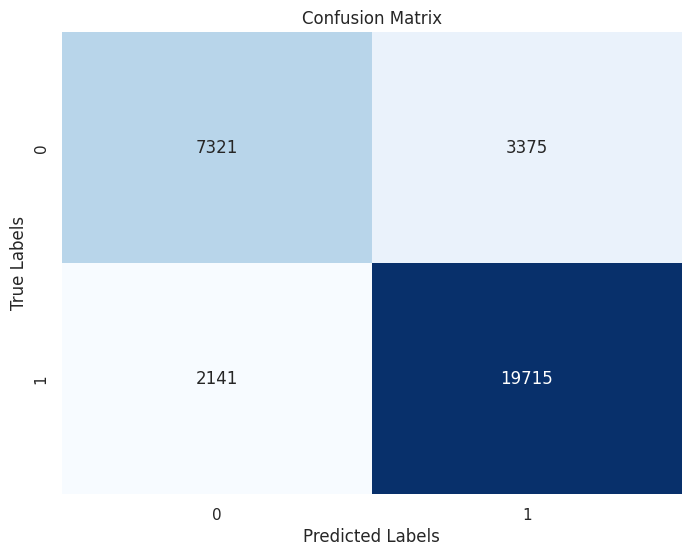

In [87]:
# Evaluating the Logistic Regression model on the test set
y_pred_log = log_classifier.predict(X_test_split)
print("Logistic Regression Classification Report:")
print(classification_report(y_test_split, y_pred_log))

conf_matrix = confusion_matrix(y_test_split, y_pred_log)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Support Vector Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.73     10696
           1       0.86      0.90      0.88     21856

    accuracy                           0.83     32552
   macro avg       0.81      0.79      0.80     32552
weighted avg       0.83      0.83      0.83     32552



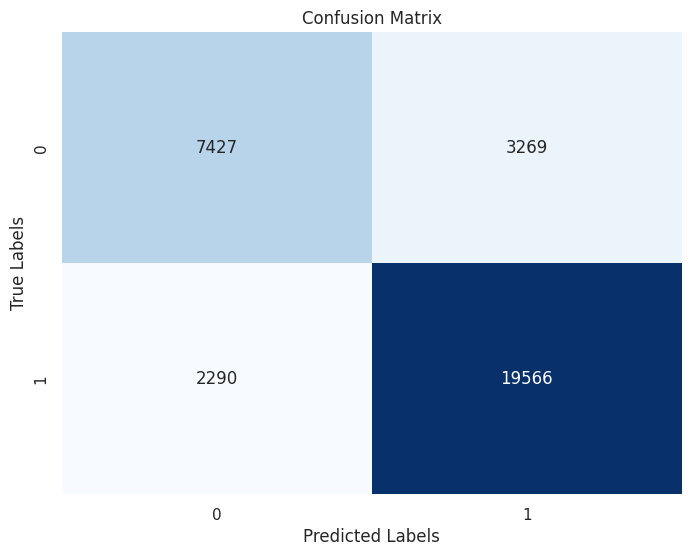

In [88]:
# Evaluating the Support Vector model on the test set
y_pred_svm = svm_classifier.predict(X_test_split)
print("Support Vector Classification Report:")
print(classification_report(y_test_split, y_pred_svm))

conf_matrix = confusion_matrix(y_test_split, y_pred_svm)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71     10696
           1       0.85      0.87      0.86     21856

    accuracy                           0.81     32552
   macro avg       0.79      0.78      0.78     32552
weighted avg       0.81      0.81      0.81     32552



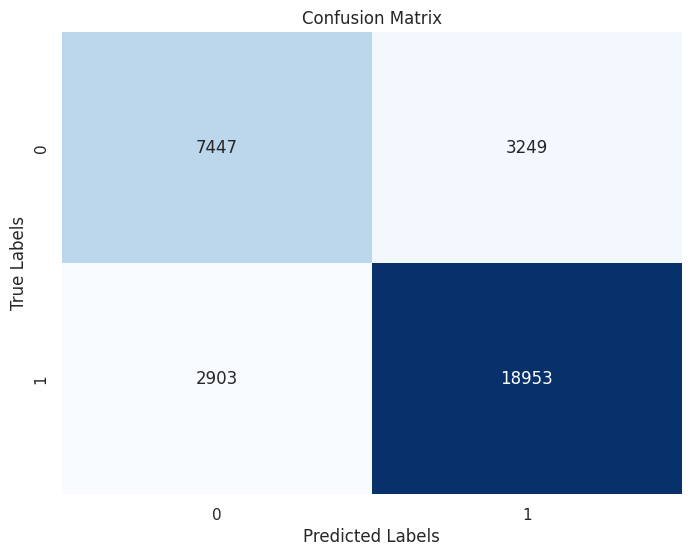

In [89]:
# Evaluating the Naive Bayes model on the test set
y_pred_naive = naive_classifier.predict(X_test_split)
print("Naive Bayes Classification Report:")
print(classification_report(y_test_split, y_pred_naive))

conf_matrix = confusion_matrix(y_test_split, y_pred_naive)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

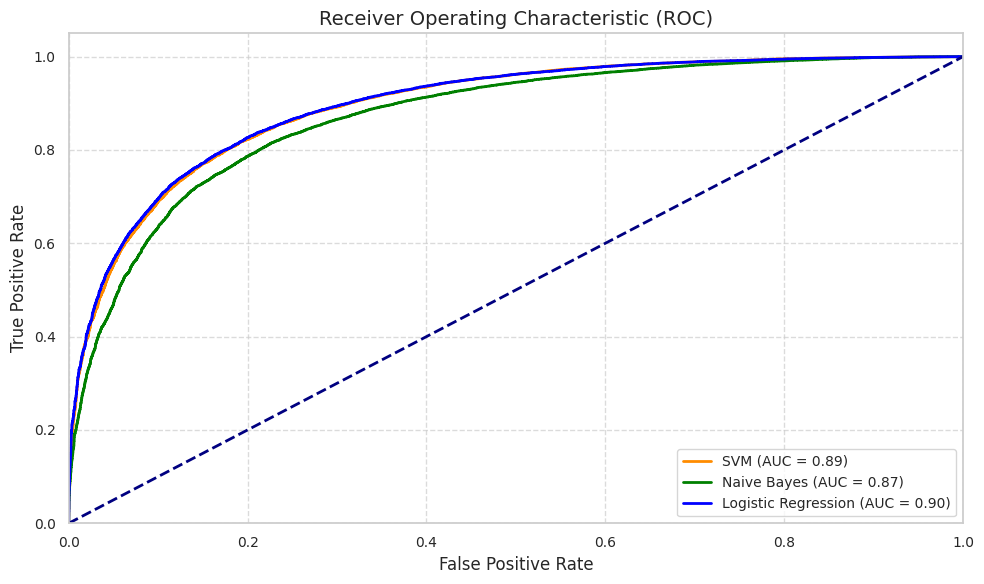

In [90]:
# Making predictions on the validation set for all 3 classifiers
y_prob_svm = svm_classifier.decision_function(X_test_split)
y_prob_naive = naive_classifier.predict_proba(X_test_split)[:, 1]
y_prob_log = log_classifier.predict_proba(X_test_split)[:, 1]

# Calculating ROC curve and AUC for all 3 classifiers
fpr_svm, tpr_svm, _ = roc_curve(y_test_split, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_naive, tpr_naive, _ = roc_curve(y_test_split, y_prob_naive)
roc_auc_naive = auc(fpr_naive, tpr_naive)

fpr_log, tpr_log, _ = roc_curve(y_test_split, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)

# Create a beautiful and clean ROC curve plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot(fpr_naive, tpr_naive, color='green', lw=2, label='Naive Bayes (AUC = %0.2f)' % roc_auc_naive)
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_log)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

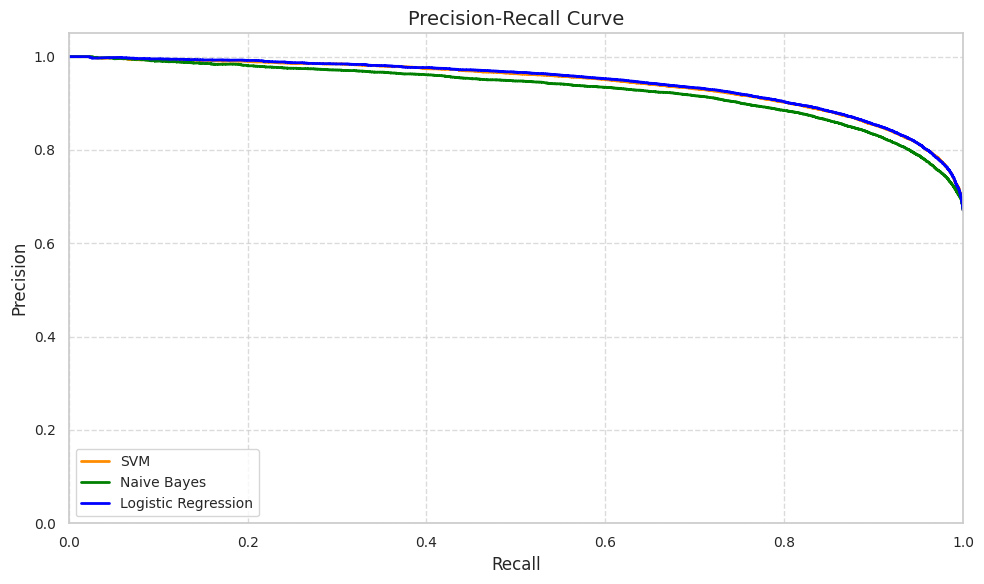

In [91]:
# Calculating precision-recall curve for all 3 classifiers
precision_svm, recall_svm, _ = precision_recall_curve(y_test_split, y_prob_svm)
precision_naive, recall_naive, _ = precision_recall_curve(y_test_split, y_prob_naive)
precision_log, recall_log, _ = precision_recall_curve(y_test_split, y_prob_log)

# Precision-Recall Curve plot
plt.figure(figsize=(10, 6))
plt.plot(recall_svm, precision_svm, color='darkorange', lw=2, label='SVM')
plt.plot(recall_naive, precision_naive, color='green', lw=2, label='Naive Bayes')
plt.plot(recall_log, precision_log, color='blue', lw=2, label='Logistic Regression')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Calibration curves are created by binning predicted probabilities, then plotting the mean predicted probability in each bin against the observed frequency ('fraction of positives')

Calibration in this context refers to how well the predicted probabilities match the actual probabilities of the predicted outcomes.

When a classifier predicts probabilities, those probabilities should ideally reflect the true likelihood of each outcome. For instance, if a classifier predicts that a sample belongs to class A with a probability of 0.8, it means that the classifier believes there's an 80% chance the sample actually belongs to class A. Calibration ensures that these predicted probabilities are accurate and reliable.

The CalibrationDisplay helps you evaluate how well the predicted probabilities align with the true probabilities. It does this by dividing the predicted probabilities into bins (e.g., [0.0-0.1], [0.1-0.2], ... [0.9-1.0]), and then calculating the actual fraction of positive outcomes within each bin. The display will plot the predicted probabilities on one axis and the actual fraction of positive outcomes on the other axis. If the plot is close to a diagonal line, it means the predicted probabilities are well-calibrated; that is, they are a good reflection of the actual outcomes.

By visually examining this plot, you can get an idea of whether your classifier's predicted probabilities are well-calibrated or not. If the plot deviates from the diagonal, it indicates a lack of calibration, suggesting that the predicted probabilities may not accurately represent the true probabilities.

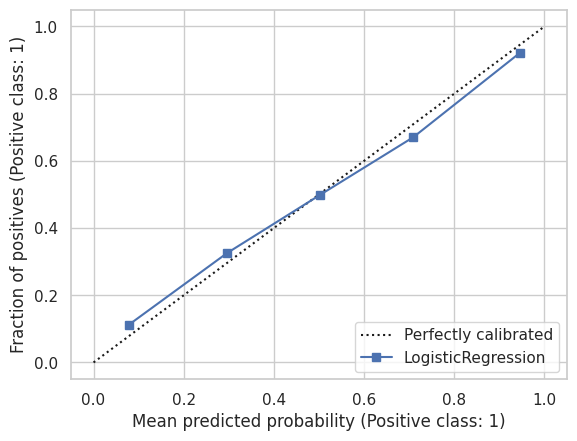

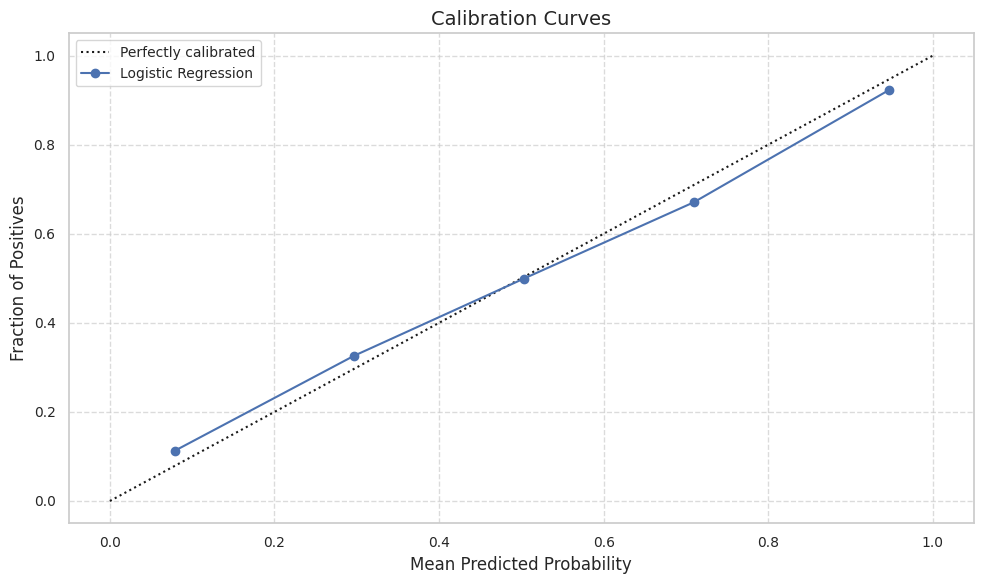

In [93]:
calibration_log = CalibrationDisplay.from_estimator(log_classifier, X_test_split, y_test_split)

# Create a beautiful and clean Calibration Curve plot for the best performing classifier
plt.figure(figsize=(10, 6))

calibration_log.plot(ax=plt.gca(), label='Logistic Regression', marker='o')

plt.title('Calibration Curves', fontsize=14)
plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('Fraction of Positives', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Important ideas learnt from the dataset and/or model

1. **Logistic Regression**:
   - Precision (Positive class): 0.85
   - Recall (Positive class): 0.90
   - F1-score (Positive class): 0.88
   - Accuracy: 0.83
   - AUC: 0.8967

   Insights:
   - The logistic regression model shows good performance with high precision, recall, and F1-score for the positive class. This indicates that the model is able to effectively identify positive sentiments.
   - The AUC score of 0.8967 indicates that the model has a strong ability to discriminate between positive and negative sentiments.

2. **Linear Support Vector Machine (SVM)**:
   - Precision (Positive class): 0.86
   - Recall (Positive class): 0.90
   - F1-score (Positive class): 0.88
   - Accuracy: 0.83
   - AUC: 0.8949

   Insights:
   - The linear SVM model performs similarly to logistic regression with high precision, recall, and F1-score for the positive class. It also effectively identifies positive sentiments.
   - The AUC score of 0.8949 indicates a strong ability to discriminate between classes, though slightly lower than logistic regression.

3. **Naive Bayes**:
   - Precision (Positive class): 0.85
   - Recall (Positive class): 0.87
   - F1-score (Positive class): 0.86
   - Accuracy: 0.81
   - AUC: 0.8729

   Insights:
   - The naive Bayes model performs well but with slightly lower precision, recall, and F1-score compared to the previous two models. It still effectively identifies positive sentiments.
   - The AUC score of 0.8729 indicates a good ability to discriminate between classes, but it is slightly lower compared to the other models.

**Overall Insights:**
- All three models show relatively good performance in terms of precision, recall, and F1-score for the positive sentiment class.
- The AUC scores for all models are above 0.87, indicating that they have a good ability to separate positive and negative sentiments.
- The logistic regression and linear SVM models are very close in terms of performance, with the highest AUC score achieved by logistic regression.
- The naive Bayes model is slightly behind in terms of precision, recall, and AUC score, but it still provides a reasonable performance for the features at hand.

Considering the results, the logistic regression seems to be a good choice for sentiment classification in this scenario.

# Submission

In [94]:
# Make predictions on the test data
predictions = log_classifier.predict(test_X)

# Generate an ID column for the submission DataFrame
ids = range(len(test_data))

# Create the submission DataFrame
submission_data = pd.DataFrame({'id': ids, 'sentiment': predictions})

# Map numerical sentiment back to the original labels
submission_data['sentiment'] = submission_data['sentiment'].map({1: 'POSITIVE', 0: 'NEGATIVE'})

# Save the submission DataFrame as submission.csv
submission_data.to_csv('submission.csv', index=False)